In [90]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention
from keras.models import Model
from keras.optimizers import Adam


In [91]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
print(data.head()) 

         Ngay  mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
0  01/01/2008        120        498.815         259.499               0.0   
1  02/01/2008        117        470.866         518.755               0.0   
2  03/01/2008        139        423.816         615.242               0.0   
3  04/01/2008        166        496.882         902.982               0.0   
4  05/01/2008        179        501.232        1072.970               0.0   

   chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
0               0.0        23.230         90.200  
1               0.0        26.239        213.791  
2               0.0        24.000        175.000  
3               0.0        11.000        164.000  
4               0.0        24.000        177.000  


In [92]:
data['Ngay'] = pd.to_datetime(data['Ngay'], format='%d/%m/%Y')
data.set_index('Ngay', inplace=True)
print(data.head()) 

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
2008-01-01        120        498.815         259.499               0.0   
2008-01-02        117        470.866         518.755               0.0   
2008-01-03        139        423.816         615.242               0.0   
2008-01-04        166        496.882         902.982               0.0   
2008-01-05        179        501.232        1072.970               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
2008-01-01               0.0        23.230         90.200  
2008-01-02               0.0        26.239        213.791  
2008-01-03               0.0        24.000        175.000  
2008-01-04               0.0        11.000        164.000  
2008-01-05               0.0        24.000        177.000  


In [109]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
print(data_scaled)

[[0.08651911 0.04639671 0.09251301 ... 0.         0.1056379  0.16986817]
 [0.08350101 0.04373844 0.18493939 ... 0.         0.1065453  0.40261959]
 [0.1056338  0.03926346 0.21933761 ... 0.         0.10587011 0.32956685]
 ...
 [0.05030181 0.0244436  0.16898396 ... 0.0771473  0.12747699 0.16129944]
 [0.04627767 0.0505992  0.12299465 ... 0.09429296 0.13279774 0.14287571]
 [0.04325956 0.07618414 0.13568271 ... 0.09247136 0.15019965 0.0433145 ]]


In [94]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
    return np.array(sequences), np.array(targets)

In [112]:
sequence_length = 7  # Sử dụng 7 ngày trước để dự báo ngày tiếp theo
X, y = create_sequences(data_scaled, sequence_length)


ValueError: Expected 2D array, got 1D array instead:
array=[0.14486922 0.16700201 0.17907445 ... 0.05030181 0.04627767 0.04325956].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [96]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [97]:
# Thay đổi hình dạng dữ liệu đầu vào cho LSTM (số mẫu, bước thời gian, số đặc trưng)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [98]:
# Xây dựng mô hình
input_layer = Input(shape=(sequence_length, X_train.shape[2]))

In [99]:
# LSTM lớp ẩn
lstm_out = LSTM(64, return_sequences=True)(input_layer)

# Lớp Attention
attention = Attention()([lstm_out, lstm_out])
attention_output = tf.reduce_sum(attention, axis=1)

# Lớp đầu ra
output = Dense(1)(attention_output)

In [100]:
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [101]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 7, 7)]               0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 7, 64)                18432     ['input_5[0][0]']             
                                                                                                  
 attention_4 (Attention)     (None, 7, 64)                0         ['lstm_4[0][0]',              
                                                                     'lstm_4[0][0]']              
                                                                                                  
 tf.math.reduce_sum_4 (TFOp  (None, 64)                   0         ['attention_4[0][0]']   

In [102]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
51/51 [==============================] - 4s 15ms/step - loss: 0.0173 - val_loss: 0.0084
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0072
Epoch 3/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0067
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/100
51/51 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 6/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 7/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 9/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 10/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 11

In [103]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

16/16 [==============================] - 0s 7ms/step - loss: 6.8944e-04
Test Loss: 0.000689444481395185


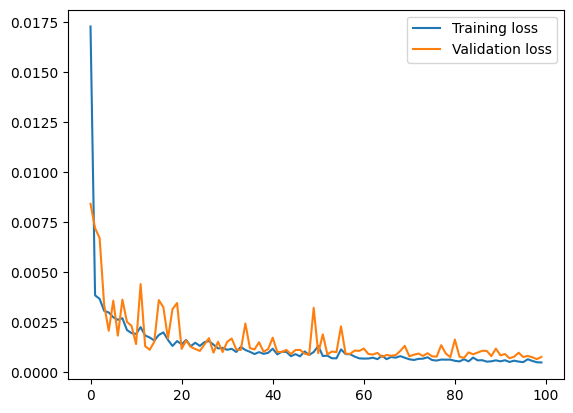

In [104]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [105]:
data_test = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2.csv')  # Thay 'your_test_file.csv' bằng đường dẫn file test của bạn
data_test['Ngay'] = pd.to_datetime(data_test['Ngay'], format='%d/%m/%Y')
data_test.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_test)

In [106]:
# Chuẩn hóa dữ liệu test bằng scaler đã huấn luyện
data_test_scaled = scaler.transform(data_test)

# Tạo các mẫu test từ dữ liệu test
X_test_new, y_test_new = create_sequences(data_test_scaled, sequence_length)

# Định dạng lại dữ liệu test để phù hợp với mô hình
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

In [107]:
predictions_new = model.predict(X_test_new)

# Chuyển đổi giá trị dự đoán và thực tế về mực nước ban đầu
# predictions_new_original = scaler.inverse_transform(np.concatenate((predictions_new, np.zeros((predictions_new.shape[0], data_test_scaled.shape[1] - 1))), axis=1))[:, 0]
# y_test_new_original = scaler.inverse_transform(np.concatenate((y_test_new.reshape(-1, 1), np.zeros((y_test_new.shape[0], data_test_scaled.shape[1] - 1))), axis=1))[:, 0]


23/23 [==============================] - 0s 3ms/step


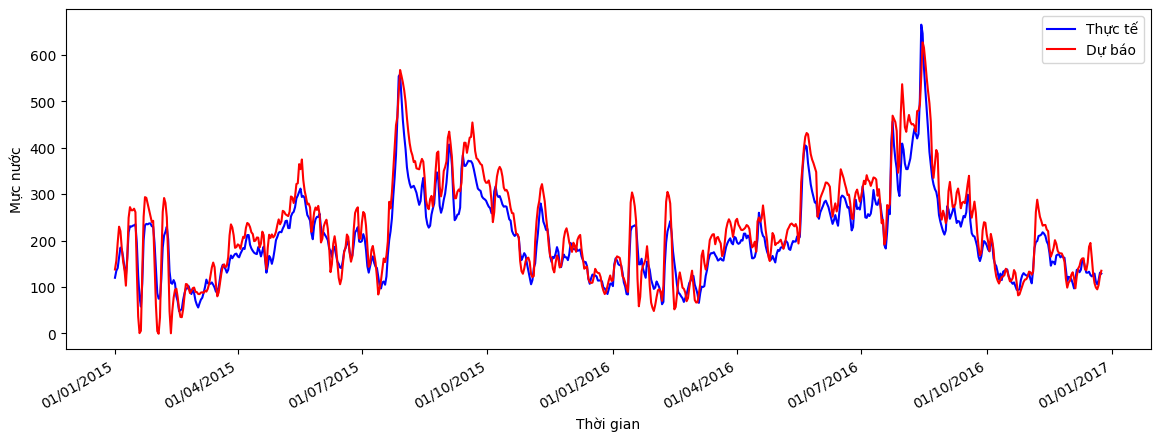

In [108]:
# Đảm bảo các mảng có cùng kích thước
min_length = min(len(data_test.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = data_test.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
